<a href="https://colab.research.google.com/github/HoCogThanh/thanh/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Xử lý file và hình ảnh
import os
import cv2
import random

# Xử lý dữ liệu và toán học
import numpy as np
from collections import Counter
from statistics import mean, stdev

# Trích xuất đặc trưng
from skimage.feature import hog
from skimage import exposure

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


'/content/drive/MyDrive/DATASET/Lua' là một thư mục hợp lệ.

Tổng số lượng ảnh trong toàn bộ dữ liệu: 8736


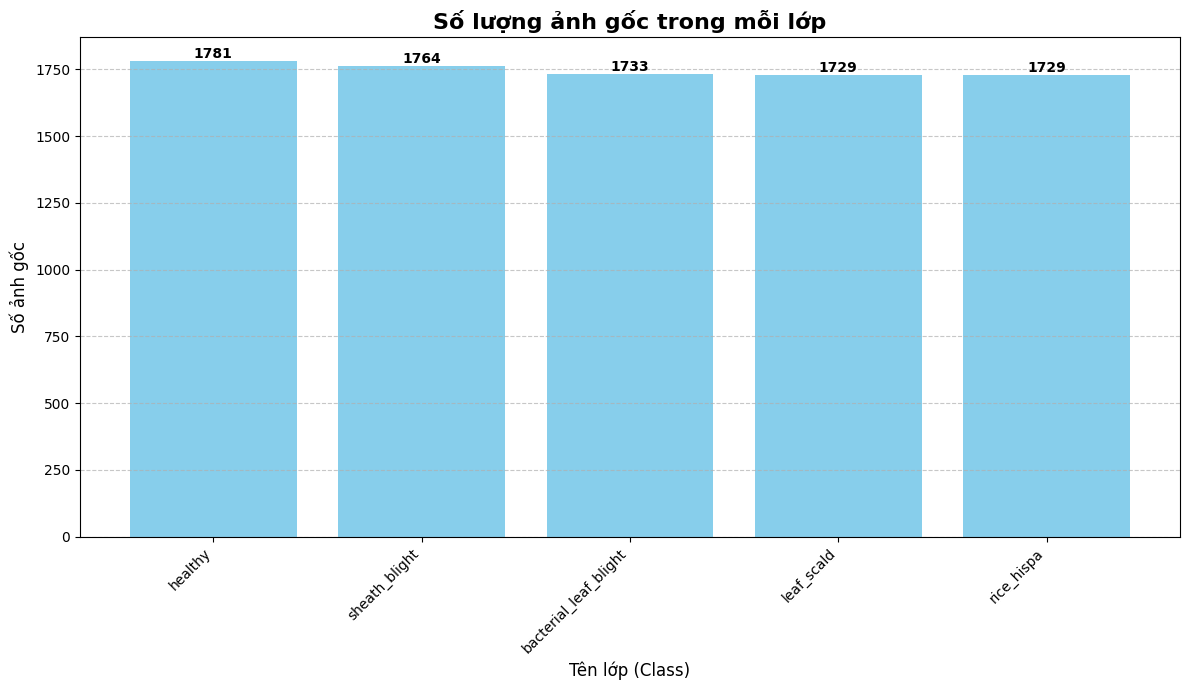

In [ ]:
#Thống kê dữ liệu

data_dir = "/content/drive/MyDrive/DATASET/Lua"

if not os.path.isdir(data_dir):
    print(f"Lỗi: '{data_dir}' không phải là một thư mục hợp lệ hoặc không tồn tại.")
    # Có thể exit() hoặc return ở đây nếu muốn dừng chương trình
else:
    print(f"'{data_dir}' là một thư mục hợp lệ.")

    # Lấy danh sách các lớp (thư mục con)
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not categories:
        print(f"Không tìm thấy thư mục lớp nào trong '{data_dir}'.")
    else:
        # Thống kê số lượng ảnh trong mỗi lớp
        original_counts = {}
        supported_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff') # Thêm các định dạng ảnh phổ biến khác

        for category in categories:
            class_path = os.path.join(data_dir, category)
            # Lọc các file có phần mở rộng ảnh hợp lệ
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(supported_extensions) and os.path.isfile(os.path.join(class_path, f))]
            original_counts[category] = len(image_files)

        # --- In ra tổng số ảnh ---
        total_images = sum(original_counts.values())
        print(f"\nTổng số lượng ảnh trong toàn bộ dữ liệu: {total_images}")

        # --- Vẽ biểu đồ số lượng ảnh gốc ---
        plt.figure(figsize=(12, 7)) # Tăng kích thước biểu đồ để dễ nhìn hơn

        # Sắp xếp các lớp theo số lượng ảnh để biểu đồ dễ đọc hơn (tùy chọn)
        sorted_counts = dict(sorted(original_counts.items(), key=lambda item: item[1], reverse=True))

        bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue') # Đổi màu cho dễ nhìn

        plt.title("Số lượng ảnh gốc trong mỗi lớp", fontsize=16, fontweight='bold')
        plt.xlabel("Tên lớp (Class)", fontsize=12)
        plt.ylabel("Số ảnh gốc", fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn và căn chỉnh
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Ghi số lượng lên cột
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, str(height), # Đặt text ngay trên cột
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

        plt.tight_layout() # Tự động điều chỉnh bố cục để tránh chồng lấn
        plt.show()

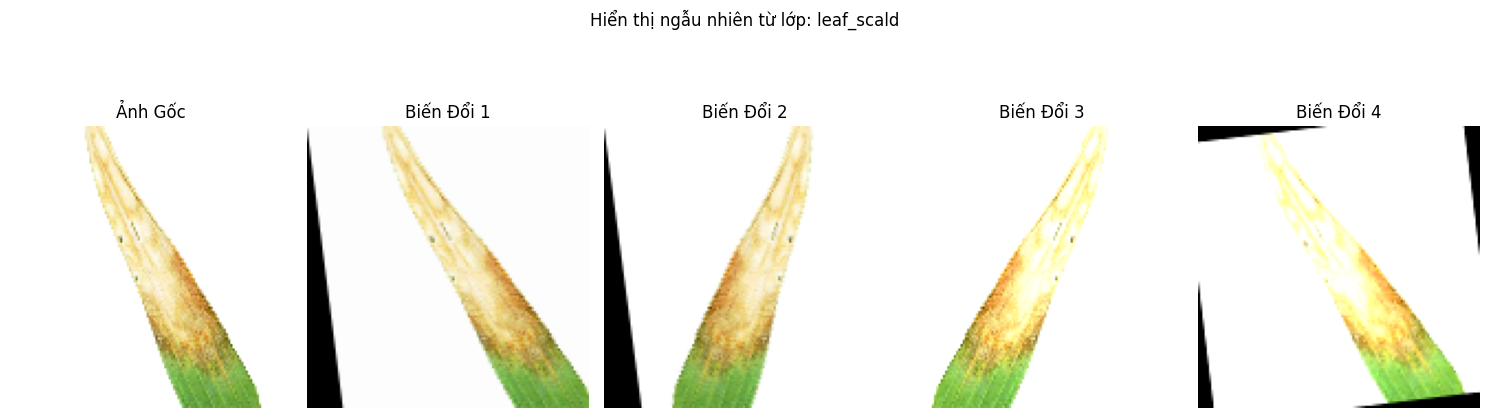


 Đã có đủ 22 batch. Bắt đầu chuẩn hóa và chia tập dữ liệu...

 Tổng số mẫu: 43680

 Đã lưu scaler vào file scaler.pkl.

✅ Đã lưu train/val/test lần 7 thành công!

 Đã chuẩn hóa, chia và lưu train/val/test thành công!


In [ ]:
#augment_image,trích xuất đặc trưng HOG và chuẩn hóa MinMaxScaler,StandardScaler

data_dir = "/content/drive/MyDrive/DATASET/Lua"
dest_dir = '/content/drive/MyDrive/Lua _5_4Au_16.4'
processed_log_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/processed_images_lua.txt"

batch_size = 2000
X_batch, y_batch = [], []

# ==== Danh sách lớp ====
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
# ==== Đảm bảo thư mục tồn tại ====
os.makedirs(dest_dir, exist_ok=True)

# ==== Các hàm augmentation ====
def rotate_image(img):
    angle = random.randint(-20, 20)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def flip_image(img):
    return cv2.flip(img, 1)

def shear_image(img):
    shear = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear, 0],
                  [0,    1, 0]], dtype=np.float32)
    (h, w) = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))

def adjust_brightness(img):
    factor = random.uniform(0.7, 1.3)
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def augment_image(img, n_augments=4):
    images = [img]
    for _ in range(n_augments):
        aug_img = img.copy()
        if random.random() < 0.5: aug_img = rotate_image(aug_img)
        if random.random() < 0.5: aug_img = flip_image(aug_img)
        if random.random() < 0.5: aug_img = shear_image(aug_img)
        if random.random() < 0.5: aug_img = adjust_brightness(aug_img)
        images.append(aug_img)
    return images

# ==== Hiển thị ảnh mẫu ====
random_category = random.choice(categories)
random_class_path = os.path.join(data_dir, random_category)
random_image_name = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

sample_img = cv2.imread(random_image_path)
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (128, 128))
    sample_augmented_images = augment_image(sample_img)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    for i, aug_img in enumerate(sample_augmented_images[1:5]):
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"Biến Đổi {i+1}")
        axes[i+1].axis('off')

    plt.suptitle(f"Hiển thị ngẫu nhiên từ lớp: {random_category}")
    plt.tight_layout()
    plt.show()

# ==== Kiểm tra batch đã tồn tại ====
batch_files = sorted([
    f for f in os.listdir(dest_dir)
    if f.startswith("hog_batch_") and f.endswith(".npz")  # <<< CHỈ hog_batch_, không "scaled"
])
existing_batches = sorted([
    int(f.split("_")[-1].split(".")[0])
    for f in batch_files
])
# Tính số ảnh gốc
total_original_images = sum(len(os.listdir(os.path.join(data_dir, c))) for c in categories)

# Mỗi ảnh tạo ra 5 ảnh (gốc + 4 augment)
total_augmented_images = total_original_images * 5

# Tính số batch cần thiết
expected_batches = int(np.ceil(total_augmented_images / batch_size))

# ==== Nếu đủ batch thì chuẩn hóa toàn bộ và chia ====
if len(batch_files) == expected_batches:
    print(f"\n Đã có đủ {len(batch_files)} batch. Bắt đầu chuẩn hóa và chia tập dữ liệu...")

    # Load toàn bộ batch
    X_all = np.concatenate([
        np.load(os.path.join(dest_dir, f))['X'] for f in batch_files
    ], axis=0)
    y_all = np.concatenate([
        np.load(os.path.join(dest_dir, f))['y'] for f in batch_files
    ], axis=0)

    print(f"\n Tổng số mẫu: {X_all.shape[0]}")

    # Chuẩn hóa toàn bộ
    #scaler = StandardScaler()
    scaler = MinMaxScaler()

    X_all_scaled = scaler.fit_transform(X_all)
    joblib.dump(scaler, os.path.join(dest_dir, "scaler.pkl"))
    print("\n Đã lưu scaler vào file scaler.pkl.")

    # Chia train/val/test
    #X_train, X_temp, y_train, y_temp = train_test_split(X_all_scaled, y_all, test_size=0.2, stratify=y_all, random_state=42)
    #X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    X_train, X_temp, y_train, y_temp = train_test_split(X_all_scaled, y_all, test_size=0.3, stratify=y_all)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
    train_round = 1
    while os.path.exists(os.path.join(dest_dir, f"X_train{train_round}.npy")):
         train_round += 1
    np.save(os.path.join(dest_dir, f"X_train{train_round}.npy"), X_train)
    np.save(os.path.join(dest_dir, f"X_val{train_round}.npy"), X_val)
    np.save(os.path.join(dest_dir, f"X_test{train_round}.npy"), X_test)
    np.save(os.path.join(dest_dir, f"y_train{train_round}.npy"), y_train)
    np.save(os.path.join(dest_dir, f"y_val{train_round}.npy"), y_val)
    np.save(os.path.join(dest_dir, f"y_test{train_round}.npy"), y_test)

    print(f"\n✅ Đã lưu train/val/test lần {train_round} thành công!")

    #np.save(os.path.join(dest_dir, "X_train.npy"), X_train)
    #np.save(os.path.join(dest_dir, "X_val.npy"), X_val)
    #np.save(os.path.join(dest_dir, "X_test.npy"), X_test)
    #np.save(os.path.join(dest_dir, "y_train.npy"), y_train)
    #np.save(os.path.join(dest_dir, "y_val.npy"), y_val)
    #np.save(os.path.join(dest_dir, "y_test.npy"), y_test)

    print("\n Đã chuẩn hóa, chia và lưu train/val/test thành công!")

# ==== Nếu chưa đủ batch thì tiếp tục trích xuất ====
else:
    print(f"\n Mới có {len(batch_files)} batch. Cần {expected_batches} batch để xử lý.")
    if existing_batches:
        last_batch = max(existing_batches)
        batch_counter = last_batch + 1
        samples_done = len(existing_batches) * batch_size
        print(f" Tiếp tục từ batch {batch_counter} (đã có {len(existing_batches)} batch)")
    else:
        batch_counter = 0
        samples_done = 0

    samples_processed = 0

    if os.path.exists(processed_log_path):
        with open(processed_log_path, "r") as f:
            processed_images = set(line.strip() for line in f)
    else:
        processed_images = set()

    for idx, category in enumerate(categories):
        class_path = os.path.join(data_dir, category)
        for img_name in os.listdir(class_path):
            image_id = f"{category}/{img_name}"
            if image_id in processed_images:
                continue

            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            augmented_images = augment_image(img)

            if samples_processed < samples_done:
                samples_processed += len(augmented_images)
                continue

            for aug_img in augmented_images:
                gray = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)
                '''
                hog_features, _ = hog(
                    gray, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4),
                    feature_vector=True,
                    visualize=True
                )
                '''
                hog_features = hog(
                    gray,
                    pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4),
                    feature_vector=True,
                    visualize=False # Sửa lỗi: Không cần visualize nếu không sử dụng
                )
                X_batch.append(hog_features)
                y_batch.append(idx)

                if len(X_batch) >= batch_size:
                    np.savez_compressed(os.path.join(dest_dir, f"hog_batch_{batch_counter}.npz"), X=np.array(X_batch), y=np.array(y_batch))
                    print(f" Đã lưu batch {batch_counter} (chưa chuẩn hóa) với {len(X_batch)} mẫu")
                    X_batch, y_batch = [], []
                    batch_counter += 1

            processed_images.add(image_id)
            with open(processed_log_path, "a") as f:
                f.write(image_id + "\n")

    if X_batch:
        np.savez_compressed(os.path.join(dest_dir, f"hog_batch_{batch_counter}.npz"), X=np.array(X_batch), y=np.array(y_batch))
        print(f" Đã lưu batch cuối {batch_counter} (chưa chuẩn hóa) với {len(X_batch)} mẫu")



===== Trực Quan Hóa Ảnh Mẫu và Đặc Trưng HOG =====

Số lượng đặc trưng HOG trích xuất: 3600


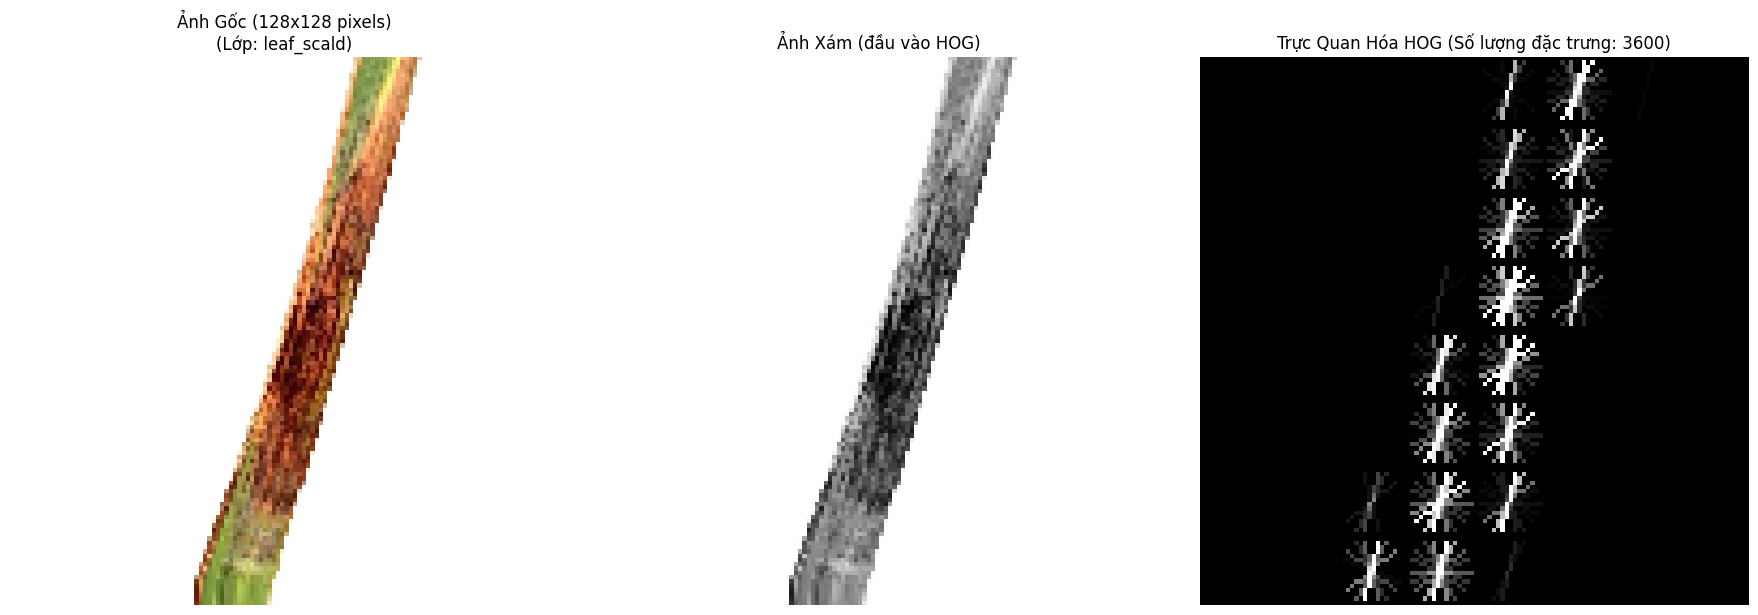

In [ ]:
#in ảnh
# ====== Cấu hình đường dẫn và thông tin (đảm bảo trùng với code gốc) ======
DATA_DIR = "/content/drive/MyDrive/DATASET/Lua" # Thư mục chứa ảnh gốc
# Các categories cần phải giống hệt như trong code xử lý dữ liệu của bạn
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# Kích thước ảnh đầu vào cho HOG (cũng phải giống với code xử lý)
HOG_IMAGE_SIZE = (128, 128)

# Tham số HOG (cũng phải giống với code xử lý)
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (4, 4)

# ====== Chọn một ảnh mẫu ngẫu nhiên để trực quan hóa ======
print("\n===== Trực Quan Hóa Ảnh Mẫu và Đặc Trưng HOG =====")

# Chọn ngẫu nhiên một lớp và một ảnh
random_category_name = np.random.choice(categories)
random_class_path = os.path.join(DATA_DIR, random_category_name)

# Đảm bảo thư mục lớp không rỗng
if not os.listdir(random_class_path):
    print(f"Lỗi: Thư mục '{random_class_path}' trống. Không thể chọn ảnh mẫu.")
    exit()

random_image_name = np.random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

# Đọc ảnh
sample_img = cv2.imread(random_image_path)

if sample_img is None:
    print(f"Lỗi: Không thể đọc ảnh từ đường dẫn: {random_image_path}")
else:
    # Chuyển đổi ảnh sang không gian màu RGB để hiển thị đúng
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Resize ảnh về kích thước chuẩn
    sample_img_resized = cv2.resize(sample_img_rgb, HOG_IMAGE_SIZE)

    # Chuyển đổi ảnh sang ảnh xám để tính HOG
    sample_img_gray = cv2.cvtColor(sample_img_resized, cv2.COLOR_RGB2GRAY)

    # Tính toán đặc trưng HOG và ảnh HOG
    # visualize=True để lấy ảnh HOG
    hog_features, hog_image = hog(
        sample_img_gray,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        feature_vector=True,
        visualize=True
    )

    # Tăng cường độ tương phản cho ảnh HOG để dễ nhìn hơn
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


    # ====== In ra số lượng đặc trưng HOG ======
    print(f"\nSố lượng đặc trưng HOG trích xuất: {len(hog_features)}")

    # ====== Hiển thị ảnh gốc, ảnh xám (đã resize) và ảnh HOG ======
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ảnh gốc (đã resize)
    axes[0].imshow(sample_img_resized)
    axes[0].set_title(f"Ảnh Gốc ({HOG_IMAGE_SIZE[0]}x{HOG_IMAGE_SIZE[1]} pixels)\n(Lớp: {random_category_name})")
    axes[0].axis('off')

    # Ảnh xám (đầu vào cho HOG)
    axes[1].imshow(sample_img_gray, cmap='gray')
    axes[1].set_title("Ảnh Xám (đầu vào HOG)")
    axes[1].axis('off')

    # Ảnh HOG (trực quan hóa các gradient)
    axes[2].imshow(hog_image_rescaled, cmap='gray') # Sử dụng ảnh HOG đã tăng cường tương phản
    axes[2].set_title(f"Trực Quan Hóa HOG (Số lượng đặc trưng: {len(hog_features)})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#SVM

# ====== Cấu hình đường dẫn ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale',probability=True)
svm_model.fit(X_train, y_train)
probs = svm_model.predict_proba(X_test)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))
# ====== Lưu mô hình SVM nếu tốt ======
if f1 >= 0.9:
    model_path = os.path.join(DATA_DIR, 'svm_model.pkl')
    joblib.dump(svm_model, model_path)
    print(f"\nĐã lưu mô hình SVM với F1-score: {f1:.4f}")
else:
    print(f"\nF1-score ({f1:.4f}) không đủ ngưỡng để lưu mô hình.")
# ====== Vẽ ma trận nhầm lẫn cho SVM ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp (SVM) ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





Số lượng mẫu:
- Train: 34944 mẫu
- Validation: 4368 mẫu
- Test: 4368 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 6932 mẫu
  healthy (3): 7124 mẫu
  leaf_scald (1): 6916 mẫu
  sheath_blight (4): 7056 mẫu
  rice_hispa (2): 6916 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  sheath_blight (4): 882 mẫu
  leaf_scald (1): 864 mẫu
  healthy (3): 891 mẫu
  rice_hispa (2): 864 mẫu
  bacterial_leaf_blight (0): 867 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  rice_hispa (2): 865 mẫu
  bacterial_leaf_blight (0): 866 mẫu
  healthy (3): 890 mẫu
  leaf_scald (1): 865 mẫu
  sheath_blight (4): 882 mẫu

Đang huấn luyện mô hình SVM...



Số lượng mẫu:
- Train: 34944 mẫu
- Validation: 4368 mẫu
- Test: 4368 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 6932 mẫu
  leaf_scald (1): 6916 mẫu
  rice_hispa (2): 6916 mẫu
  healthy (3): 7124 mẫu
  sheath_blight (4): 7056 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 867 mẫu
  leaf_scald (1): 864 mẫu
  rice_hispa (2): 864 mẫu
  healthy (3): 891 mẫu
  sheath_blight (4): 882 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 866 mẫu
  leaf_scald (1): 865 mẫu
  rice_hispa (2): 865 mẫu
  healthy (3): 890 mẫu
  sheath_blight (4): 882 mẫu

✅ Mô hình vòng 1 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Accuracy: 94.94% | F1-score: 0.9495

💡 Phát hiện vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng 2.

🔁 Bắt đầu huấn luyện SVM vòng thứ 2:
✅ Test  | Accuracy: 94.71% | F1-score: 0.9472
📊 Val   | Accuracy: 94.53% | F1-score: 0.9453
💾 Đã lưu mô hình vòng 2 vào: /content/drive/MyDrive/Lua _5_4Au_16

<ipython-input-3-cac791788ed6>:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


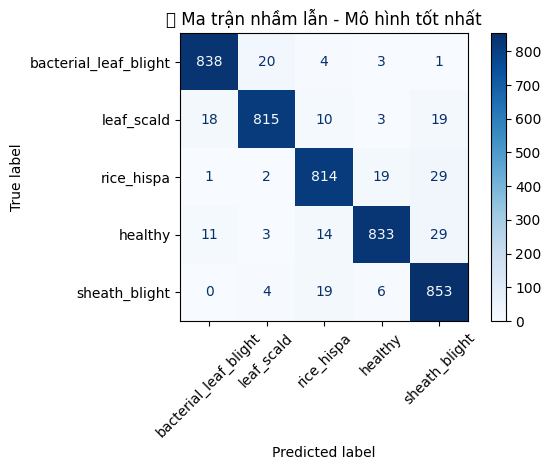

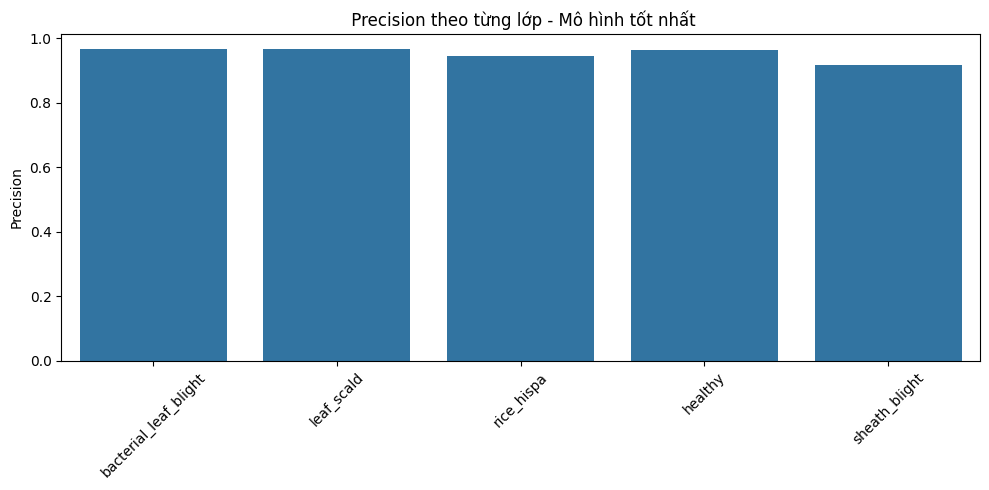


💾 Đã lưu mô hình SVM tốt nhất với F1-score: 0.9508 vào: /content/drive/MyDrive/Lua _5_4Au_16.4/svm_model_best.pkl


In [ ]:
# Train 6 lần SVM

DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'
MODEL_SAVE_DIR = os.path.join(DATA_DIR, 'saved_svm_rounds') # Thư mục để lưu các mô hình của từng vòng
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Tạo thư mục nếu chưa tồn tại

# Tải dữ liệu ban đầu (có thể là X_train3, y_train3, v.v. như trong code gốc)
# Các file này sẽ được tải lại trong vòng lặp cho từng round
X_train_initial = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val_initial   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test_initial  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train_initial = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val_initial   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test_initial  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu (sử dụng dữ liệu ban đầu để in tổng quan) ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train_initial)} mẫu")
print(f"- Validation: {len(X_val_initial)} mẫu")
print(f"- Test: {len(X_test_initial)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các lớp theo nhãn để đảm bảo thứ tự nhất quán
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train_initial, "Train")
print_class_distribution(y_val_initial, "Validation")
print_class_distribution(y_test_initial, "Test")

accuracy_list = []
f1_list = []
best_f1 = -1
best_model = None
best_preds = None
best_y_test = None

num_rounds = 6

# Xác định vòng huấn luyện bắt đầu
start_round = 1
# Kiểm tra các mô hình đã lưu để tìm vòng chưa hoàn thành
for i in range(1, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')
    if not os.path.exists(model_path_round):
        start_round = i
        print(f"\n💡 Phát hiện vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng {start_round}.")
        break
    else:
        print(f"\n✅ Mô hình vòng {i} đã tồn tại. Tải và đánh giá lại.")
        # Tải dữ liệu cho vòng này để đánh giá lại
        X_test_round = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))
        y_test_round = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

        loaded_model = joblib.load(model_path_round)
        y_pred_test_loaded = loaded_model.predict(X_test_round)
        acc_test_loaded = accuracy_score(y_test_round, y_pred_test_loaded)
        f1_test_loaded = f1_score(y_test_round, y_pred_test_loaded, average='weighted')

        accuracy_list.append(acc_test_loaded)
        f1_list.append(f1_test_loaded)

        print(f"   Đã tải | Accuracy: {acc_test_loaded*100:.2f}% | F1-score: {f1_test_loaded:.4f}")

        # Cập nhật mô hình tốt nhất từ các mô hình đã tải
        if f1_test_loaded > best_f1:
            best_f1 = f1_test_loaded
            best_model = loaded_model
            best_preds = y_pred_test_loaded
            best_y_test = y_test_round

# Bắt đầu vòng lặp huấn luyện từ vòng đã xác định
for i in range(start_round, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')

    # Nếu mô hình cho vòng này đã tồn tại, bỏ qua huấn luyện
    if os.path.exists(model_path_round):
        print(f"\n🔄 Vòng huấn luyện SVM thứ {i} đã hoàn thành trước đó. Bỏ qua huấn luyện lại.")
        # Dữ liệu và kết quả đã được xử lý ở bước kiểm tra trước vòng lặp
        continue

    print(f"\n🔁 Bắt đầu huấn luyện SVM vòng thứ {i}:")

    # Tải dữ liệu cho vòng hiện tại
    X_train = np.load(os.path.join(DATA_DIR, f'X_train{i}.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))

    y_train = np.load(os.path.join(DATA_DIR, f'y_train{i}.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

    # Khởi tạo và huấn luyện mô hình
    model = SVC(kernel='rbf', C=20.0, gamma='scale')
    model.fit(X_train, y_train)

    # Dự đoán trên test set
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Dự đoán trên validation set
    y_pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val, average='weighted')

    accuracy_list.append(acc_test)
    f1_list.append(f1_test)

    print(f"✅ Test  | Accuracy: {acc_test*100:.2f}% | F1-score: {f1_test:.4f}")
    print(f"📊 Val   | Accuracy: {acc_val*100:.2f}% | F1-score: {f1_val:.4f}")

    # Cập nhật mô hình tốt nhất
    if f1_test > best_f1:
        best_f1 = f1_test
        best_model = model
        best_preds = y_pred_test
        best_y_test = y_test

    # Lưu mô hình của vòng hiện tại
    joblib.dump(model, model_path_round)
    print(f"💾 Đã lưu mô hình vòng {i} vào: {model_path_round}")


# ==== Tổng kết ====
print("\n Kết quả tổng hợp:")
if accuracy_list: # Đảm bảo danh sách không rỗng trước khi tính toán
    print(f"- Accuracy trung bình: {mean(accuracy_list)*100:.2f}%")
    print(f"- Accuracy std       : {stdev(accuracy_list)*100:.2f}")
    print(f"- F1-score trung bình: {mean(f1_list):.4f}")
    print(f"- F1-score std       : {stdev(f1_list):.4f}")
else:
    print("- Không có kết quả nào được ghi nhận.")

# ==== In kết quả mô hình tốt nhất ====
if best_model:
    print("\n🏆 Mô hình có F1-score cao nhất:")
    print(f"- F1-score: {best_f1:.4f}")
    print(classification_report(best_y_test, best_preds, target_names=categories))

    # ==== Vẽ ma trận nhầm lẫn ====
    cm = confusion_matrix(best_y_test, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("🏆 Ma trận nhầm lẫn - Mô hình tốt nhất")
    plt.tight_layout()
    plt.show()

    # ==== Vẽ biểu đồ precision theo từng lớp ====
    report = classification_report(best_y_test, best_preds, target_names=categories, output_dict=True)
    precision_values = [report[cat]['precision'] for cat in categories]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values)
    plt.ylabel("Precision")
    plt.title(" Precision theo từng lớp - Mô hình tốt nhất")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== Lưu mô hình tốt nhất (nếu chưa được lưu) ====
    # Mô hình tốt nhất có thể là một trong các mô hình đã được lưu ở trên
    # Nếu bạn muốn lưu một bản sao riêng biệt của mô hình tốt nhất, hãy làm như sau:
    model_best_path = os.path.join(DATA_DIR, 'svm_model_best.pkl')
    joblib.dump(best_model, model_best_path)
    print(f"\n💾 Đã lưu mô hình SVM tốt nhất với F1-score: {best_f1:.4f} vào: {model_best_path}")
else:
    print("\n⚠️ Không tìm thấy mô hình tốt nhất (có thể do không có vòng huấn luyện nào hoàn thành).")




Đang huấn luyện mô hình Random Forest...

[Random Forest] Accuracy (val): 85.60%
[Random Forest] F1-score (val): 0.8590

[Random Forest] Accuracy (test): 87.71%
[Random Forest] F1-score (test): 0.8790

[Random Forest] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.90      0.93       866
           leaf_scald       0.93      0.87      0.90       865
           rice_hispa       0.78      0.87      0.82       865
              healthy       0.97      0.83      0.89       890
        sheath_blight       0.78      0.92      0.84       882

             accuracy                           0.88      4368
            macro avg       0.89      0.88      0.88      4368
         weighted avg       0.89      0.88      0.88      4368



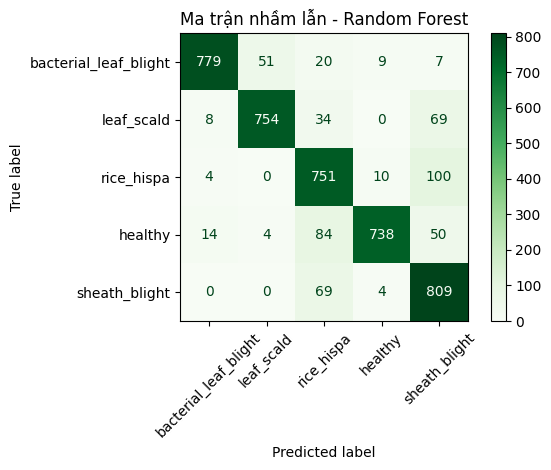

In [ ]:
#  Mô hình Random Forest

# ====== Cấu hình đường dẫn ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
print("\nĐang huấn luyện mô hình Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred_rf = rf_model.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"\n[Random Forest] Accuracy (val): {val_acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (val): {val_f1_rf:.4f}")

# ====== Đánh giá trên tập test ======
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n[Random Forest] Accuracy (test): {acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (test): {f1_rf:.4f}")
print("\n[Random Forest] Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn cho Random Forest ======
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=categories)
disp_rf.plot(cmap="Greens", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - Random Forest")
plt.tight_layout()
plt.show()


Đã tải dữ liệu từ X_train3.npy và các file liên quan.

Số lượng mẫu đã tải:
- Train: 34944 mẫu
- Validation: 4368 mẫu
- Test: 4368 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
   - bacterial_leaf_blight (0): 6932 mẫu
   - leaf_scald (1): 6916 mẫu
   - rice_hispa (2): 6916 mẫu
   - healthy (3): 7124 mẫu
   - sheath_blight (4): 7056 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
   - bacterial_leaf_blight (0): 867 mẫu
   - leaf_scald (1): 864 mẫu
   - rice_hispa (2): 864 mẫu
   - healthy (3): 891 mẫu
   - sheath_blight (4): 882 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
   - bacterial_leaf_blight (0): 866 mẫu
   - leaf_scald (1): 865 mẫu
   - rice_hispa (2): 865 mẫu
   - healthy (3): 890 mẫu
   - sheath_blight (4): 882 mẫu

Đang huấn luyện mô hình K-Nearest Neighbors...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Các siêu tham số tốt nhất cho KNN: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
F1-score tốt nhất trên tập huấn luyện (GridSearchCV) cho KNN

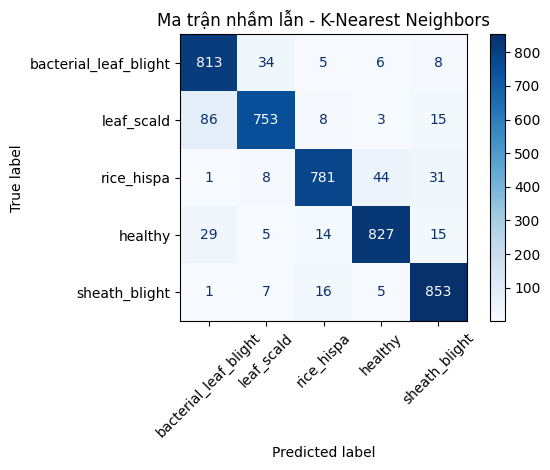

<ipython-input-3-2514ddbb3496>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=precision_values_knn, palette='viridis')


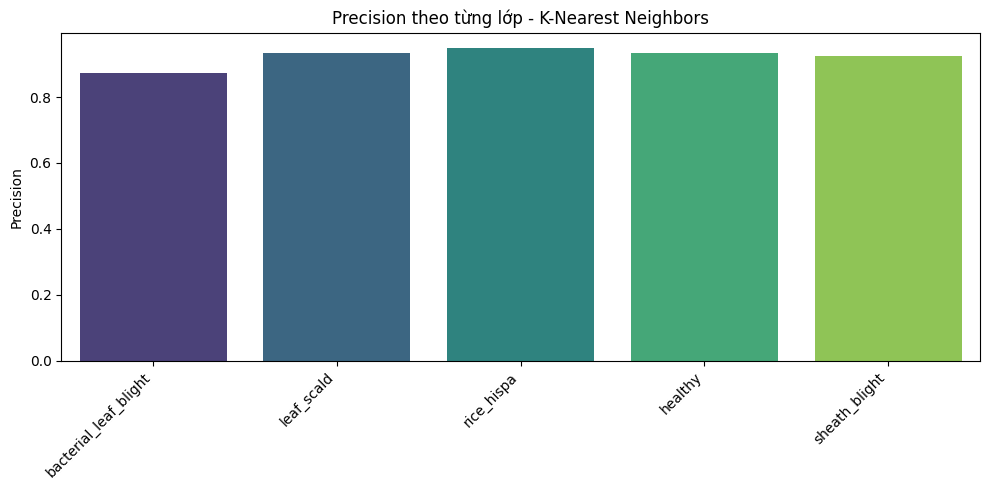

In [ ]:
#Mô hình KNN

# ====== Cấu hình đường dẫn và thông tin ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Hàm in phân phối lớp (tái sử dụng) ======
def print_class_distribution(y, split_name, categories):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label} (Chưa xác định)"
        print(f"   - {class_name} ({label}): {count} mẫu")

# ====== Tải và kiểm tra dữ liệu ======
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))
    print("Đã tải dữ liệu từ X_train3.npy và các file liên quan.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy các file dữ liệu tại {DATA_DIR}. Vui lòng kiểm tra lại đường dẫn và tên file.")
    exit()

# Tổng số lượng mẫu
print(f"\nSố lượng mẫu đã tải:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# In ra số lượng mẫu theo từng lớp
print_class_distribution(y_train, "Train", categories)
print_class_distribution(y_val, "Validation", categories)
print_class_distribution(y_test, "Test", categories)

# Kết hợp tập huấn luyện và validation cho GridSearchCV
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

# ====== Huấn luyện mô hình K-Nearest Neighbors ======
print("\nĐang huấn luyện mô hình K-Nearest Neighbors...")

# Định nghĩa các tham số mà bạn muốn thử cho KNN
param_grid_knn = {
    'n_neighbors': [5],
    'weights': ['distance'],
    'p': [2]
}
knn_base = KNeighborsClassifier()

# Khởi tạo GridSearchCV để tìm kiếm siêu tham số tốt nhất
grid_search_knn = GridSearchCV(estimator=knn_base, param_grid=param_grid_knn,
                               cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

grid_search_knn.fit(X_train_combined, y_train_combined)

print(f"\nCác siêu tham số tốt nhất cho KNN: {grid_search_knn.best_params_}")
print(f"F1-score tốt nhất trên tập huấn luyện (GridSearchCV) cho KNN: {grid_search_knn.best_score_:.4f}")

# Lấy mô hình KNN tốt nhất từ GridSearchCV
best_knn_model = grid_search_knn.best_estimator_
print("\nĐã tìm thấy mô hình K-Nearest Neighbors tốt nhất.")

# ====== Đánh giá trên tập test với mô hình KNN tốt nhất ======
print("\nĐánh giá mô hình K-Nearest Neighbors tốt nhất trên tập test...")
y_pred_knn = best_knn_model.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\n[K-Nearest Neighbors] Accuracy (test): {acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (test): {f1_knn:.4f}")
print("\n[K-Nearest Neighbors] Báo cáo phân loại:")
print(classification_report(y_test, y_pred_knn, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn cho K-Nearest Neighbors ======
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=categories)
disp_knn.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - K-Nearest Neighbors")
plt.tight_layout()
plt.show()

# ====== Vẽ biểu đồ precision theo từng lớp cho K-Nearest Neighbors ======
report_knn = classification_report(y_test, y_pred_knn, target_names=categories, output_dict=True)
precision_values_knn = [report_knn[cat]['precision'] for cat in categories if cat in report_knn]

if len(precision_values_knn) == len(categories):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_knn)
    plt.ylabel("Precision")
    plt.title("Precision theo từng lớp - K-Nearest Neighbors")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Cảnh báo: Không thể vẽ biểu đồ Precision cho KNN do số lượng lớp không khớp.")



Số lượng mẫu đã tải:
- Train: 34944 mẫu
- Validation: 4368 mẫu
- Test: 4368 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
   - bacterial_leaf_blight (0): 6932 mẫu
   - leaf_scald (1): 6916 mẫu
   - rice_hispa (2): 6916 mẫu
   - healthy (3): 7124 mẫu
   - sheath_blight (4): 7056 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
   - bacterial_leaf_blight (0): 867 mẫu
   - leaf_scald (1): 864 mẫu
   - rice_hispa (2): 864 mẫu
   - healthy (3): 891 mẫu
   - sheath_blight (4): 882 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
   - bacterial_leaf_blight (0): 866 mẫu
   - leaf_scald (1): 865 mẫu
   - rice_hispa (2): 865 mẫu
   - healthy (3): 890 mẫu
   - sheath_blight (4): 882 mẫu

Đang huấn luyện mô hình Logistic Regression...

Đã huấn luyện mô hình Logistic Regression với các tham số cố định.

Đánh giá mô hình Logistic Regression trên tập test...

[Logistic Regression] Accuracy (test): 80.77%
[Logistic Regression] F1-score (test): 0.8081

[Logistic Regression] Báo cáo phân loại:
 

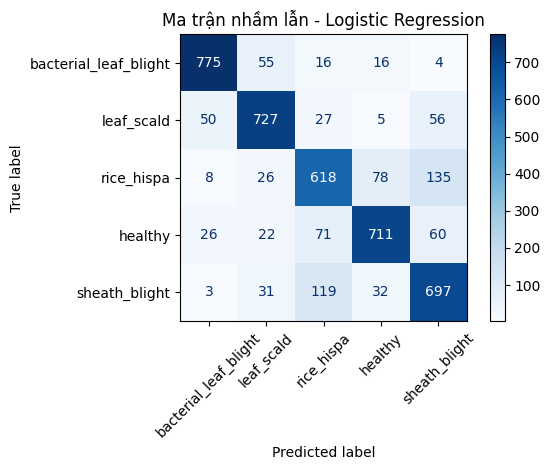

<ipython-input-2-a8546446373d>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=precision_values_lr, palette='viridis')


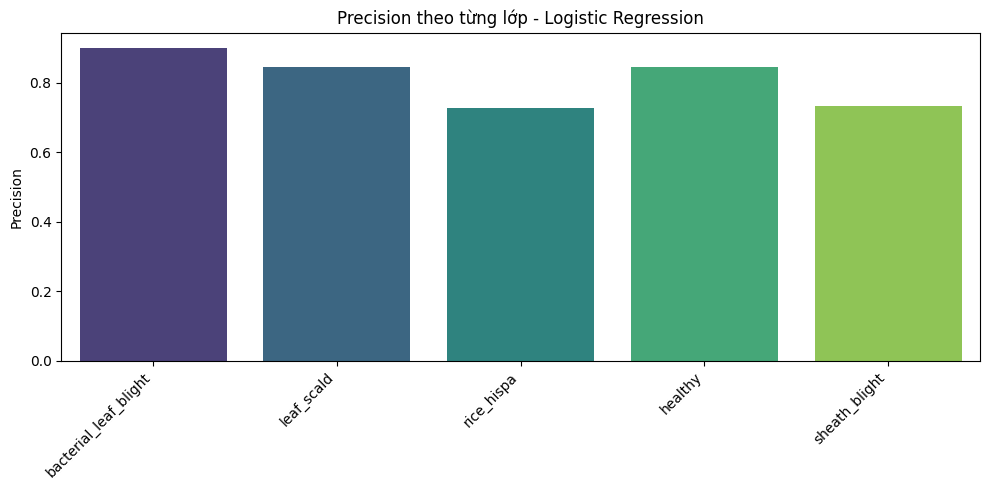

In [ ]:
# LogisticRegression

# ====== Cấu hình đường dẫn và thông tin ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Hàm in phân phối lớp (tái sử dụng) ======
def print_class_distribution(y, split_name, categories):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label} (Chưa xác định)"
        print(f"   - {class_name} ({label}): {count} mẫu")

# ====== Tải và kiểm tra dữ liệu ======
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy các file dữ liệu tại {DATA_DIR}. Vui lòng kiểm tra lại đường dẫn và tên file.")
    exit()

# Tổng số lượng mẫu
print(f"\nSố lượng mẫu đã tải:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# In ra số lượng mẫu theo từng lớp
print_class_distribution(y_train, "Train", categories)
print_class_distribution(y_val, "Validation", categories)
print_class_distribution(y_test, "Test", categories)

# Kết hợp tập huấn luyện và validation cho huấn luyện mô hình
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

# ====== Huấn luyện mô hình Logistic Regression ======
print("\nĐang huấn luyện mô hình Logistic Regression...")

best_lr_model = LogisticRegression(
    C=10,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    n_jobs=-1 # Sử dụng tất cả các lõi CPU
)

# Huấn luyện mô hình trực tiếp
best_lr_model.fit(X_train_combined, y_train_combined)

print("\nĐã huấn luyện mô hình Logistic Regression với các tham số cố định.")
print("\nĐánh giá mô hình Logistic Regression trên tập test...")
y_pred_lr = best_lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n[Logistic Regression] Accuracy (test): {acc_lr*100:.2f}%")
print(f"[Logistic Regression] F1-score (test): {f1_lr:.4f}")
print("\n[Logistic Regression] Báo cáo phân loại:")
print(classification_report(y_test, y_pred_lr, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn cho Logistic Regression ======
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=categories)
disp_lr.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - Logistic Regression")
plt.tight_layout()
plt.show()

# ====== Vẽ biểu đồ precision theo từng lớp cho Logistic Regression ======
report_lr = classification_report(y_test, y_pred_lr, target_names=categories, output_dict=True)
precision_values_lr = [report_lr[cat]['precision'] for cat in categories if cat in report_lr and 'precision' in report_lr[cat]]

if len(precision_values_lr) == len(categories):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_lr, palette='viridis')
    plt.ylabel("Precision")
    plt.title("Precision theo từng lớp - Logistic Regression")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Cảnh báo: Không thể vẽ biểu đồ Precision cho Logistic Regression do số lượng lớp không khớp hoặc thiếu dữ liệu.")

In [ ]:
# Tìm tham số cho SVM

# ====== Cấu hình đường dẫn ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
svm = SVC()
param_grid = {
    'C': [ 20],
    'kernel':[ 'rbf'],
    'gamma': [0.01, 0.1]
}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best score: {best_score}")
print(f"Best parameters: {best_params}")

In [ ]:
import os
import cv2
from skimage.feature import hog
import joblib
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def preprocess_and_extract_features(image_path, scaler):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Không tìm thấy file: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Lỗi khi đọc ảnh (cv2.imread trả về None): {image_path}")

    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feature = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4), feature_vector=True)
    hog_feature = scaler.transform([hog_feature])

    return hog_feature[0], image_path # Trả về mảng 1D và đường dẫn

def predict_batch_images(image_folder, model, scaler):

    if not os.path.isdir(image_folder):
        raise NotADirectoryError(f"Đường dẫn không phải là thư mục: {image_folder}")

    predictions_results = []
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff') # Các định dạng ảnh hỗ trợ

    print(f"Bắt đầu dự đoán hàng loạt ảnh trong thư mục: {image_folder}\n")

    for filename in os.listdir(image_folder):
        # Lọc các file ảnh theo định dạng
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                # Tiền xử lý và trích xuất đặc trưng cho từng ảnh
                hog_feature, processed_path = preprocess_and_extract_features(image_path, scaler)

                # Dự đoán nhãn lớp
                prediction_label_index = model.predict([hog_feature])[0] # model.predict() vẫn cần 2D array
                predicted_class_name = categories[prediction_label_index]

                predictions_results.append((processed_path, prediction_label_index, predicted_class_name))
                print(f"Ảnh '{filename}' -> Dự đoán: {predicted_class_name}")

            except (FileNotFoundError, ValueError, Exception) as e:
                print(f"Lỗi khi xử lý ảnh '{filename}': {e}")
                predictions_results.append((image_path, -1, f"Lỗi: {e}")) # Ghi lại lỗi
    print("\nHoàn tất dự đoán hàng loạt.")
    return predictions_results

model_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/svm_model_best.pkl"
scaler_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/scaler.pkl"

# Kiểm tra sự tồn tại của file model và scaler
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Không tìm thấy mô hình: {model_path}")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Không tìm thấy scaler: {scaler_path}")

# Tải model và scaler
svm_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

test_image_folder = "/content/drive/MyDrive/DATASET/Test_Model"

# Gọi hàm dự đoán hàng loạt
all_predictions = predict_batch_images(test_image_folder, svm_model, scaler)

print("\n--- TÓM TẮT KẾT QUẢ DỰ ĐOÁN ---")
for img_path, label_index, class_name in all_predictions:
    # Nếu có lỗi, label_index sẽ là -1
    if label_index != -1:
        print(f"Ảnh: {os.path.basename(img_path)} -> Lớp dự đoán: {class_name}")
    else:
        print(f"Ảnh: {os.path.basename(img_path)} -> Kết quả: {class_name}")

Bắt đầu dự đoán hàng loạt ảnh trong thư mục: /content/drive/MyDrive/DATASET/Test_Model

Ảnh 'healthy2.jpg' -> Dự đoán: healthy
Ảnh 'healthy1.jpg' -> Dự đoán: healthy
Ảnh 'rice_hispa1.jpg' -> Dự đoán: rice_hispa
Ảnh 'rice_hispa2.jpg' -> Dự đoán: rice_hispa
Ảnh 'sheath_blight1.jpg' -> Dự đoán: sheath_blight
Ảnh 'sheath_blight2.jpg' -> Dự đoán: sheath_blight
Ảnh 'leaf scald2.png' -> Dự đoán: rice_hispa
Ảnh 'bacterial_leaf_blight 1.png' -> Dự đoán: bacterial_leaf_blight

Hoàn tất dự đoán hàng loạt.

--- TÓM TẮT KẾT QUẢ DỰ ĐOÁN ---
Ảnh: healthy2.jpg -> Lớp dự đoán: healthy
Ảnh: healthy1.jpg -> Lớp dự đoán: healthy
Ảnh: rice_hispa1.jpg -> Lớp dự đoán: rice_hispa
Ảnh: rice_hispa2.jpg -> Lớp dự đoán: rice_hispa
Ảnh: sheath_blight1.jpg -> Lớp dự đoán: sheath_blight
Ảnh: sheath_blight2.jpg -> Lớp dự đoán: sheath_blight
Ảnh: leaf scald2.png -> Lớp dự đoán: rice_hispa
Ảnh: bacterial_leaf_blight 1.png -> Lớp dự đoán: bacterial_leaf_blight
